## ENSO influence on Antarctic coastal ocean

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame


Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape

nc = Dataset('/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output200/ocean.nc', mode='r') # file handle, open in read only mode
dzt = nc.variables['dzt'][0,:,:,:]
nc.close() # close the file

print dzt.shape
#dzt=np.squeeze(dzt)
#print dzt.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)
(50, 1080, 1440)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.7


The Bellingshausen Sea is an area along the west side of the Antarctic Peninsula between 57°18'W and 102°20'W, west of Alexander Island, east of Cape Flying Fish on Thurston Island, and south of Peter I Island (there the southern Vostokkysten).

WAP range
i=821 to 872

BS range
i=716 to i=820

AS range
i=613 to i=714

In [5]:
NYFCntrlDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080_cp/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
#NYFPertDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/'


In [37]:
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

In [6]:
#print ht[0:50,1000]
#print tanom[0,st,0:50,1000]
#msk=np.ones((tanom.shape[2],tanom.shape[3]))
#msk[np.where(ht[0:250,:]>1000)]=0
#msk[np.where(ht[0:250,:]<0)]=0

#print msk[0:50,1000]

(1788, 1)
1175
(1980, 1)
1367
here (50, 1) (50, 1)
[ 1968.] [ 1968.] 1958
(613, 1) (60,)


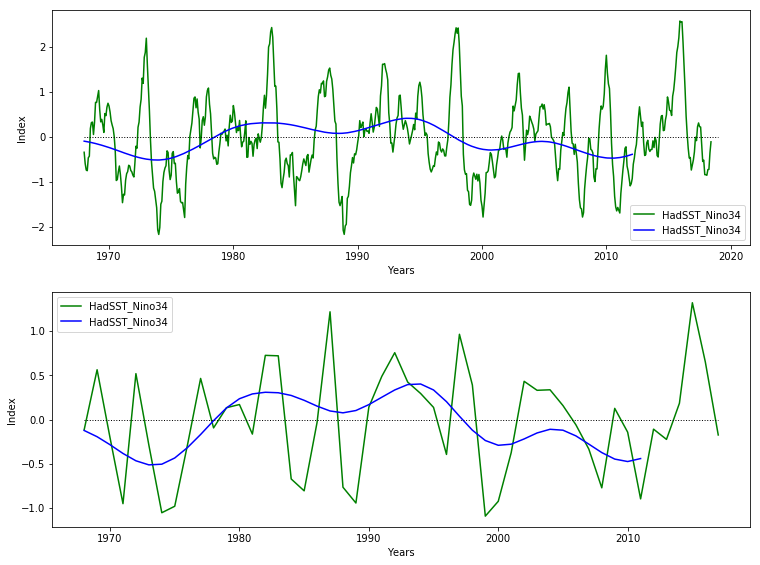

In [50]:
#n34yr = year
#n34mn = month
#n34yrd = year + month/12
#it's 1870-2018
hadsst = sp.io.loadmat('/g/data1a/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/HadISST_Nino3p4.mat')#,'bat_lat')
hadsst_n34yr=hadsst['n34yr']
hadsst_n34yrd=hadsst['n34yrd']
hadsst_n34=hadsst['n34']
print hadsst_n34yrd.shape
hadsst_yri = nonzero(hadsst_n34yrd == 1968)[0][0]
print hadsst_yri

#print ERSST_ipo[ERSST_yri:ERSST_yri+12]
hadsst_n34_ann=np.zeros((50,1))
i=hadsst_yri
for t in range(50):
        #print hadsst_yri
        hadsst_n34_ann[t]=np.mean(hadsst_n34[i:i+12])
        i=i+12


#ipo = time series
#ipoyr = year
#ipomn = month
#ipoyrd = year + month/12 (edited)
ERSST= sp.io.loadmat('/g/data1a/v45/pas561/mom/archive/gfdl_nyf_iafAntSOI/TPI_ERSSTV5_IPOindex.mat')
ERSST_ipo=ERSST['ipo']
ERSST_ipoyrd=ERSST['ipoyrd']
ERSST_ipoyr=ERSST['ipoyr']
print ERSST_ipo.shape
ERSST_yri = nonzero(ERSST_ipoyrd == 1968)[0][0]
print ERSST_yri

#print ERSST_ipo[ERSST_yri:ERSST_yri+12]
ERSST_ipo_ann=np.zeros((50,1))
i=ERSST_yri
for t in range(50):
        #print ERSST_yri
        ERSST_ipo_ann[t]=np.mean(ERSST_ipo[i:i+12])
        i=i+12

plt.subplot(211)
plt.plot(hadsst_n34yrd[hadsst_yri:],hadsst_n34[hadsst_yri:],linestyle='-',color='g',label='HadSST_Nino34',linewidth=1.5)
plt.plot(ERSST_ipoyrd[ERSST_yri:],ERSST_ipo[ERSST_yri:],linestyle='-',color='b',label='HadSST_Nino34',linewidth=1.5)
plt.plot(ERSST_ipoyrd[ERSST_yri:],np.zeros((ERSST_ipoyrd[ERSST_yri:].shape)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Index')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('Nino34')
plt.legend(fontsize=10)


yrs=np.arange(1958,2018,1)
print 'here', hadsst_n34_ann.shape, ERSST_ipo_ann.shape
print hadsst_n34yrd[hadsst_yri], ERSST_ipoyrd[ERSST_yri], yrs[0]
print hadsst_n34yrd[hadsst_yri:].shape, yrs.shape

plt.subplot(212)
plt.plot(yrs[10:],hadsst_n34_ann,linestyle='-',color='g',label='HadSST_Nino34',linewidth=1.5)
plt.plot(yrs[10:],ERSST_ipo_ann,linestyle='-',color='b',label='HadSST_Nino34',linewidth=1.5)
plt.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Index')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('Nino34')
plt.legend(fontsize=10)


In [51]:
df= pd.DataFrame(hadsst_n34_ann)
hadsst_n34_ann_5yr = df.rolling(window=5, center=True).mean().values
print hadsst_n34_ann_5yr.shape


(50, 1)


In [10]:
#look at the access-om2 jra iaf run
#ocean.jra_iaf.temp.90to119.cat.diff90to119avg.nc
#/g/data3/hh5/tmp/pas561/access-om2-jra-iaf
#g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf

In [11]:
#OM2_025_PertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
##Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.60to89.cat.diff60t89avg.nc')
##print Ocean_File
#pert_jra_cyc3=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print pert_jra_cyc3.temp.shape

In [25]:
OM_025_PertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.temp.90to119.cat.diff90to119avg.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.temp.shape

yrs=np.arange(1958,2018,1)
print yrs.shape

/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean.jra_iaf.temp.90to119.cat.diff90to119avg.nc
(60, 50, 501, 1440)
(60,)


In [28]:
IAFPertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
#Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.120to149.cat.diff120to149avg.nc')
#print Ocean_File
#pert_jra_cyc5=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print pert_jra_cyc5.temp.shape

In [29]:
#print pert.st_ocean[18]

1972
14
1982
24
1997
39
2015
57


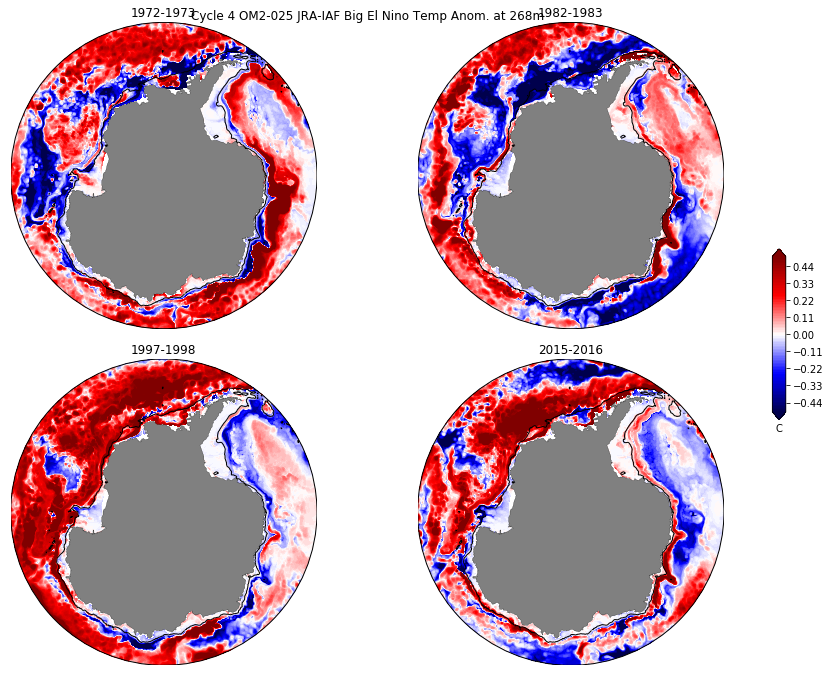

In [30]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 4 OM2-025 JRA-IAF Big El Nino Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle4_OM2_025_JRA-IAF_Temp_EN_anom.png')
plt.savefig(of,dpi=220)



In [31]:
#1988 1999 2007 2010

1988
30
1999
41
2007
49
2010
52


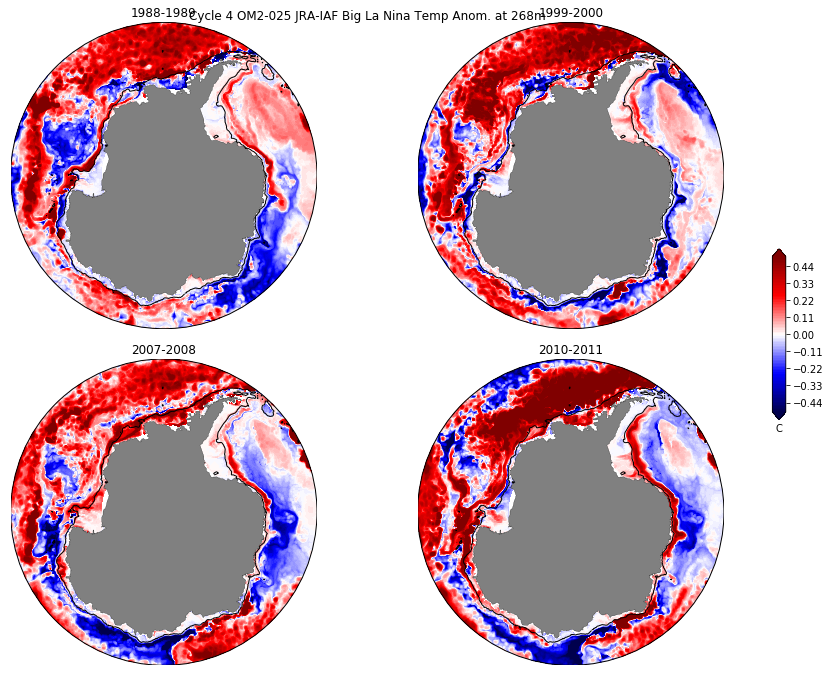

In [32]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 4 OM2-025 JRA-IAF Big La Nina Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle4_OM2_025_JRA-IAF_Temp_LN_anom.png')
plt.savefig(of,dpi=220)



In [33]:
nc = Dataset('/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean_grid.nc', mode='r') # file handle, open in read only mode
ht = nc.variables['ht'][:,:]
area_t= nc.variables['area_t'][:,:]
nc.close() # close the file
print ht.shape
print area_t.shape

(1080, 1440)
(1080, 1440)


In [34]:
#msk=np.ones((hi_anom_ann.shape[1],hi_anom_ann[2]))
msk=np.ones((250,1440))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
#print st_ocean[st]

wi1=821
wi2=872
bi1=716
bi2=820
ai1=613
ai2=714

wap_tpert=np.zeros((60,1))
bs_tpert=np.zeros((60,1))
as_tpert=np.zeros((60,1))
for yr in range(0,60):
    print yr
    wap_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    warea=np.sum(area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_tpert[yr]=wap_tpert[yr]/warea
    
    bs_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    barea=np.sum(area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_tpert[yr]=bs_tpert[yr]/barea
    
    as_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    aarea=np.sum(area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_tpert[yr]=as_tpert[yr]/aarea
    

4.26866e+14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [45]:
print yrs
print as_tpert.shape

[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
(60, 1)


(50, 1) (50, 1)
LinregressResult(slope=0.71231024268770926, intercept=-0.00030124726589931053, rvalue=0.28615743121489762, pvalue=0.043946033646890134, stderr=0.344264173324491)
R$^2$=0.08, P=0.04
(50, 1) (50, 1)
LinregressResult(slope=-0.32875681672002133, intercept=-0.029129581119683841, rvalue=-0.096526336463037515, pvalue=0.50487398537707306, stderr=0.48930044046960958)
R$^2$=0.01, P=0.50
(50, 1) (50, 1)
LinregressResult(slope=-0.001003824284718935, intercept=-0.023924745381112594, rvalue=-0.00016732224111431059, pvalue=0.99907986304594854, stderr=0.86593122502577535)
R$^2$=0.00, P=1.00


Text(1970,0.09,'R$^2$=0.00, P=1.00')

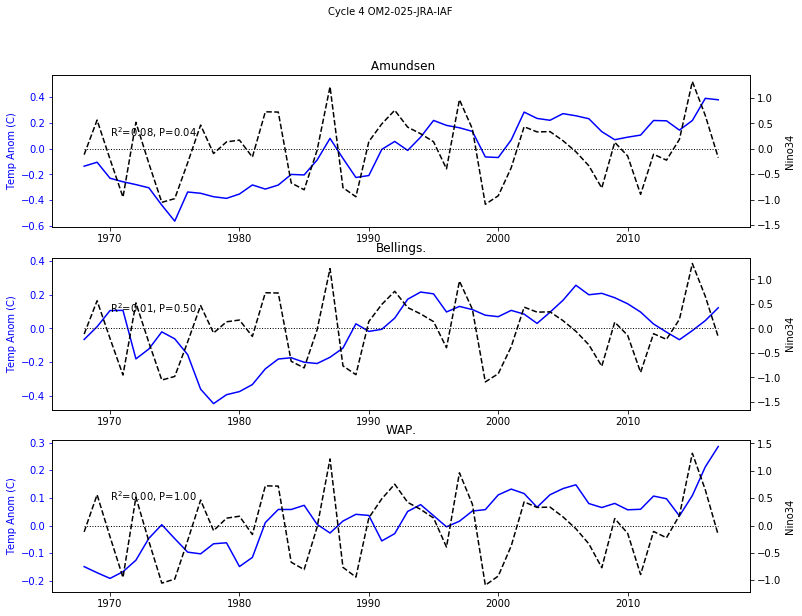

In [46]:
plt.suptitle('Cycle 4 OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

In [52]:
#as_tpert_5yr=pd.rolling_mean(as_tpert, window=5, center=True)
#bs_tpert_5yr=pd.rolling_mean(bs_tpert, window=5, center=True)
#wap_tpert_5yr=pd.rolling_mean(wap_tpert, window=5, center=True)

df= pd.DataFrame(as_tpert)
as_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(bs_tpert)
bs_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(wap_tpert)
wap_tpert_5yr = df.rolling(window=5, center=True).mean().values

plt.suptitle('Cycle 4 5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('HadSST_Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

(50, 1) (50, 1)
LinregressResult(slope=0.30447649661590642, intercept=-0.029936227157725662, rvalue=0.26427713950564397, pvalue=0.075932510925294378, stderr=0.16751207029256193)
R$^2$=0.07, P=0.08
(50, 1) (50, 1)
LinregressResult(slope=-0.010572745767112637, intercept=-0.0433896299871726, rvalue=-0.0068885076770139487, pvalue=0.96376068850275898, stderr=0.23138009766528114)
R$^2$=0.00, P=0.96
(50, 1) (50, 1)
LinregressResult(slope=0.47739320608088492, intercept=-0.052587937297541548, rvalue=0.14217388156733543, pvalue=0.34592001883437673, stderr=0.50106702204636588)
R$^2$=0.02, P=0.35


Text(1970,0.09,'R$^2$=0.02, P=0.35')

In [53]:
as_tpert_cyc4=as_tpert
bs_tpert_cyc4=bs_tpert
wap_tpert_cyc4=wap_tpert

as_tpert_5yr_cyc4=as_tpert_5yr
bs_tpert_5yr_cyc4=bs_tpert_5yr
wap_tpert_5yr_cyc4=wap_tpert_5yr


In [54]:
OM2_025_PertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.120to149.cat.diff120to149avg.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.temp.shape

/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean.jra_iaf.120to149.cat.diff120to149avg.nc
(60, 50, 501, 1440)


In [55]:
print pert.st_ocean[18]

<xarray.DataArray 'st_ocean' ()>
array(228.1881444592732)
Coordinates:
    st_ocean  float64 228.2
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


In [56]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 5 OM2-025 JRA-IAF Big El Nino Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle5_OM2_025_JRA-IAF_Temp_EN_anom.png')
plt.savefig(of,dpi=220)



1972
14
1982
24
1997
39
2015
57


In [57]:
#1988 1999 2007 2010

In [61]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 5 OM2-025 JRA-IAF Big La Nina Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle5_OM2_025_JRA-IAF_Temp_LN_anom.png')
plt.savefig(of,dpi=220)



1988
30
1999
41
2007
49
2010
52


In [62]:
nc = Dataset('/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean_grid.nc', mode='r') # file handle, open in read only mode
ht = nc.variables['ht'][:,:]
area_t= nc.variables['area_t'][:,:]
nc.close() # close the file
print ht.shape
print area_t.shape

(1080, 1440)
(1080, 1440)


In [63]:
#msk=np.ones((hi_anom_ann.shape[1],hi_anom_ann[2]))
msk=np.ones((250,1440))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
#print st_ocean[st]

wi1=821
wi2=872
bi1=716
bi2=820
ai1=613
ai2=714

wap_tpert=np.zeros((60,1))
bs_tpert=np.zeros((60,1))
as_tpert=np.zeros((60,1))
for yr in range(0,60):
    print yr
    wap_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    warea=np.sum(area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_tpert[yr]=wap_tpert[yr]/warea
    
    bs_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    barea=np.sum(area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_tpert[yr]=bs_tpert[yr]/barea
    
    as_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    aarea=np.sum(area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_tpert[yr]=as_tpert[yr]/aarea
    

4.26866e+14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [64]:
print yrs

[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


In [65]:
plt.suptitle('Cycle 5 OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

(50, 1) (50, 1)
LinregressResult(slope=0.13266298889361669, intercept=-0.025639075739611789, rvalue=0.13221802569181207, pvalue=0.36003260042272156, stderr=0.14355186392715663)
R$^2$=0.02, P=0.36
(50, 1) (50, 1)
LinregressResult(slope=0.070195610410149586, intercept=-0.025176236506137109, rvalue=0.058263811714841442, pvalue=0.6877511790711357, stderr=0.17360092909604632)
R$^2$=0.00, P=0.69
(50, 1) (50, 1)
LinregressResult(slope=0.078576780574759766, intercept=-0.025121385741830128, rvalue=0.023351387811675325, pvalue=0.87212114353502934, stderr=0.48555952279177855)
R$^2$=0.00, P=0.87


Text(1970,0.09,'R$^2$=0.00, P=0.87')

In [66]:
#as_tpert_5yr=pd.rolling_mean(as_tpert, window=5, center=True)
#bs_tpert_5yr=pd.rolling_mean(bs_tpert, window=5, center=True)
#wap_tpert_5yr=pd.rolling_mean(wap_tpert, window=5, center=True)
df= pd.DataFrame(as_tpert)
as_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(bs_tpert)
bs_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(wap_tpert)
wap_tpert_5yr = df.rolling(window=5, center=True).mean().values

plt.suptitle('Cycle 5 5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

(50, 1) (50, 1)
LinregressResult(slope=0.093881119045927094, intercept=-0.043835881434792195, rvalue=0.21472269106602795, pvalue=0.15185281492681227, stderr=0.064376012747147091)
R$^2$=0.05, P=0.15
(50, 1) (50, 1)
LinregressResult(slope=0.067317881034906893, intercept=-0.044468957185288677, rvalue=0.13108175437270292, pvalue=0.38521472630217068, stderr=0.076753521525218096)
R$^2$=0.02, P=0.39
(50, 1) (50, 1)
LinregressResult(slope=0.1834098423470221, intercept=-0.04714839683512774, rvalue=0.11900931335396148, pvalue=0.43084149228830282, stderr=0.230684204880821)
R$^2$=0.01, P=0.43


Text(1970,0.09,'R$^2$=0.01, P=0.43')

In [67]:
as_tpert_cyc5=as_tpert
bs_tpert_cyc5=bs_tpert
wap_tpert_cyc5=wap_tpert

as_tpert_5yr_cyc5=as_tpert_5yr
bs_tpert_5yr_cyc5=bs_tpert_5yr
wap_tpert_5yr_cyc5=wap_tpert_5yr

In [68]:
OM2_025_PertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.60to89.cat.diff60t89avg.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.temp.shape

/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean.jra_iaf.60to89.cat.diff60t89avg.nc
(60, 50, 501, 1440)


In [69]:
print pert.st_ocean[18]

<xarray.DataArray 'st_ocean' ()>
array(228.1881444592732)
Coordinates:
    st_ocean  float64 228.2
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


In [71]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 3 OM2-025 JRA-IAF Big El Nino Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle3_OM2_025_JRA-IAF_Temp_EN_anom.png')
plt.savefig(of,dpi=220)



1972
14
1982
24
1997
39
2015
57


In [ ]:
#1988 1999 2007 2010

In [72]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 3 OM2-025 JRA-IAF Big La Nina Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle3_OM2_025_JRA-IAF_Temp_LN_anom.png')
plt.savefig(of,dpi=220)



1988
30
1999
41
2007
49
2010
52


In [73]:
nc = Dataset('/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean_grid.nc', mode='r') # file handle, open in read only mode
ht = nc.variables['ht'][:,:]
area_t= nc.variables['area_t'][:,:]
nc.close() # close the file
print ht.shape
print area_t.shape

(1080, 1440)
(1080, 1440)


In [74]:
#msk=np.ones((hi_anom_ann.shape[1],hi_anom_ann[2]))
msk=np.ones((250,1440))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
#print st_ocean[st]

wi1=821
wi2=872
bi1=716
bi2=820
ai1=613
ai2=714

wap_tpert=np.zeros((60,1))
bs_tpert=np.zeros((60,1))
as_tpert=np.zeros((60,1))
for yr in range(0,60):
    print yr
    wap_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    warea=np.sum(area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_tpert[yr]=wap_tpert[yr]/warea
    
    bs_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    barea=np.sum(area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_tpert[yr]=bs_tpert[yr]/barea
    
    as_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    aarea=np.sum(area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_tpert[yr]=as_tpert[yr]/aarea
    

4.26866e+14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [75]:
print yrs

[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


In [76]:
plt.suptitle('Cycle 3 OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

(50, 1) (50, 1)
LinregressResult(slope=0.1401314470239218, intercept=-0.027276277683360911, rvalue=0.12716285705198532, pvalue=0.3788514453535502, stderr=0.15776645066558107)
R$^2$=0.02, P=0.38
(50, 1) (50, 1)
LinregressResult(slope=0.036057230934838327, intercept=-0.024123183005304971, rvalue=0.024560412278107728, pvalue=0.86555970987608921, stderr=0.21183858861618859)
R$^2$=0.00, P=0.87
(50, 1) (50, 1)
LinregressResult(slope=0.31589926583895728, intercept=-0.028960178238850109, rvalue=0.071741026339110336, pvalue=0.6205339759101669, stderr=0.63392797657454591)
R$^2$=0.01, P=0.62


Text(1970,0.09,'R$^2$=0.01, P=0.62')

In [77]:
#as_tpert_5yr=pd.rolling_mean(as_tpert, window=5, center=True)
#bs_tpert_5yr=pd.rolling_mean(bs_tpert, window=5, center=True)
#wap_tpert_5yr=pd.rolling_mean(wap_tpert, window=5, center=True)
df= pd.DataFrame(as_tpert)
as_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(bs_tpert)
bs_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(wap_tpert)
wap_tpert_5yr = df.rolling(window=5, center=True).mean().values

plt.suptitle('Cycle 3 5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
ax2.set_ylabel('Nino34')#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

(50, 1) (50, 1)
LinregressResult(slope=0.10938691399026081, intercept=-0.045443620924964831, rvalue=0.22686132874103285, pvalue=0.12948162446867079, stderr=0.070795393105151178)
R$^2$=0.05, P=0.13
(50, 1) (50, 1)
LinregressResult(slope=0.058689662442612887, intercept=-0.04315625217911101, rvalue=0.093627857454377822, pvalue=0.53598160771760417, stderr=0.094084535423314825)
R$^2$=0.01, P=0.54
(50, 1) (50, 1)
LinregressResult(slope=0.51272914311409012, intercept=-0.052926568740350871, rvalue=0.24628281036512922, pvalue=0.098958125521422816, stderr=0.30418659860542491)
R$^2$=0.06, P=0.10


Text(1970,0.09,'R$^2$=0.06, P=0.10')

In [78]:
as_tpert_cyc3=as_tpert
bs_tpert_cyc3=bs_tpert
wap_tpert_cyc3=wap_tpert

as_tpert_5yr_cyc3=as_tpert_5yr
bs_tpert_5yr_cyc3=bs_tpert_5yr
wap_tpert_5yr_cyc3=wap_tpert_5yr

In [79]:
OM2_025_PertDir='/g/data3/hh5/tmp/pas561/access-om2-jra-iaf'
Ocean_File = os.path.join(OM2_025_PertDir,'ocean.jra_iaf.30to59.cat.diff.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.temp.shape

/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean.jra_iaf.30to59.cat.diff.nc
(60, 50, 501, 1440)


In [80]:
print pert.st_ocean[18]

<xarray.DataArray 'st_ocean' ()>
array(228.1881444592732)
Coordinates:
    st_ocean  float64 228.2
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean


In [81]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 2 OM2-025 JRA-IAF Big El Nino Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1972)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1982)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1997)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2015)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle2_OM2_025_JRA-IAF_Temp_EN_anom.png')
plt.savefig(of,dpi=220)



1972
14
1982
24
1997
39
2015
57


In [82]:
#1988 1999 2007 2010

1988
30
1999
41
2007
49
2010
52


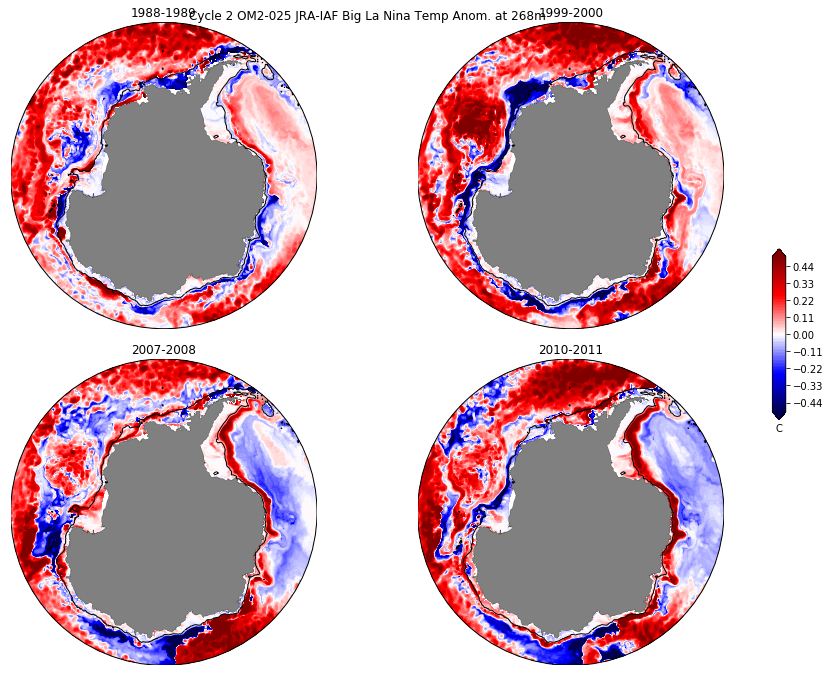

In [83]:
#plot temp anom
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Cycle 2 OM2-025 JRA-IAF Big La Nina Temp Anom. at 268m')
clev = np.arange(-.5,0.51,.01)
yrs=np.arange(1958,2018,1)
#print pert.st_ocean[18]
st=18

yr = nonzero(yrs == 1988)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 1999)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2007)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))

yr = nonzero(yrs == 2010)[0][0]
print yrs[yr]
print yr

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-60,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
X, Y = map(geolon_t[0:250,:],geolat_t[0:250,:]) 
p1=map.contourf(X,Y,pert.temp[yr:yr+1,st,0:250,:].mean('time').load(), cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = 1000
map.contour(X,Y,ht[0:250,:],levels=clev3,colors='k',linewidths=1)
plt.title(yrs[yr].astype('S4')+'-'+yrs[yr+1].astype('S4'))


ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(IAFPertDir,'Cycle2_OM2_025_JRA-IAF_Temp_LN_anom.png')
plt.savefig(of,dpi=220)



In [84]:
nc = Dataset('/g/data3/hh5/tmp/pas561/access-om2-jra-iaf/ocean_grid.nc', mode='r') # file handle, open in read only mode
ht = nc.variables['ht'][:,:]
area_t= nc.variables['area_t'][:,:]
nc.close() # close the file
print ht.shape
print area_t.shape

(1080, 1440)
(1080, 1440)


In [85]:
#msk=np.ones((hi_anom_ann.shape[1],hi_anom_ann[2]))
msk=np.ones((250,1440))
msk[np.where(ht[0:250,:]>1000)]=0
msk[np.where(ht[0:250,:]<0)]=0

print np.nansum(area_t)
#print st_ocean[st]

wi1=821
wi2=872
bi1=716
bi2=820
ai1=613
ai2=714

wap_tpert=np.zeros((60,1))
bs_tpert=np.zeros((60,1))
as_tpert=np.zeros((60,1))
for yr in range(0,60):
    print yr
    wap_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,wi1:wi2]*area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    warea=np.sum(area_t[0:250,wi1:wi2]*msk[:,wi1:wi2])
    wap_tpert[yr]=wap_tpert[yr]/warea
    
    bs_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,bi1:bi2]*area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    barea=np.sum(area_t[0:250,bi1:bi2]*msk[:,bi1:bi2])
    bs_tpert[yr]=bs_tpert[yr]/barea
    
    as_tpert[yr]=np.nansum(pert.temp[yr,st,0:250,ai1:ai2]*area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    aarea=np.sum(area_t[0:250,ai1:ai2]*msk[:,ai1:ai2])
    as_tpert[yr]=as_tpert[yr]/aarea
    

4.26866e+14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [86]:
print yrs

[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


(50, 1) (50, 1)
LinregressResult(slope=2.1067400629225244, intercept=0.053986452195745424, rvalue=0.45360345784757777, pvalue=0.00093849576069725998, stderr=0.59743536054111179)
R$^2$=0.21, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=-0.082182837215869664, intercept=-0.029342989585098629, rvalue=-0.015313655928855249, pvalue=0.91593843543325304, stderr=0.77451654231327938)
R$^2$=0.00, P=0.92
(50, 1) (50, 1)
LinregressResult(slope=0.75489527897981845, intercept=-0.028872724099686581, rvalue=0.10589113633546203, pvalue=0.46423783987483358, stderr=1.0231937309591881)
R$^2$=0.01, P=0.46


Text(1970,0.09,'R$^2$=0.01, P=0.46')

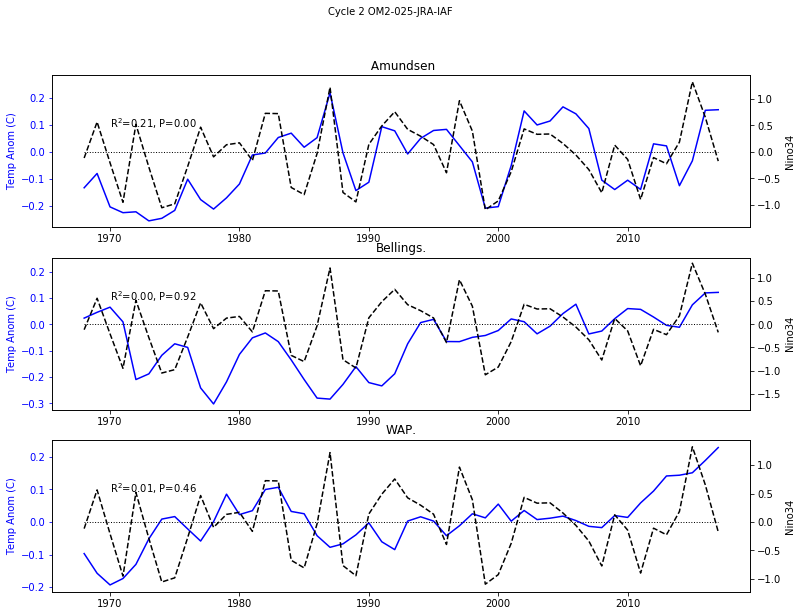

In [87]:
plt.suptitle('Cycle 2 OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert[10:]
b=hadsst_n34_ann
print a.shape, b.shape
c= sp.stats.linregress(a[:,0],b[:,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

(50, 1) (50, 1)
LinregressResult(slope=1.4992414424007827, intercept=0.013775013437040608, rvalue=0.5750369808507767, pvalue=2.915719050505144e-05, stderr=0.32156621374773109)
R$^2$=0.33, P=0.00
(50, 1) (50, 1)
LinregressResult(slope=0.14200312344262742, intercept=-0.032209912785337205, rvalue=0.049378239666820756, pvalue=0.74451380471436823, stderr=0.43301790880281843)
R$^2$=0.00, P=0.74
(50, 1) (50, 1)
LinregressResult(slope=1.2181410269597046, intercept=-0.049135676892239272, rvalue=0.29041602200441385, pvalue=0.05023977707902378, stderr=0.60508645829806218)
R$^2$=0.08, P=0.05


Text(1970,0.09,'R$^2$=0.08, P=0.05')

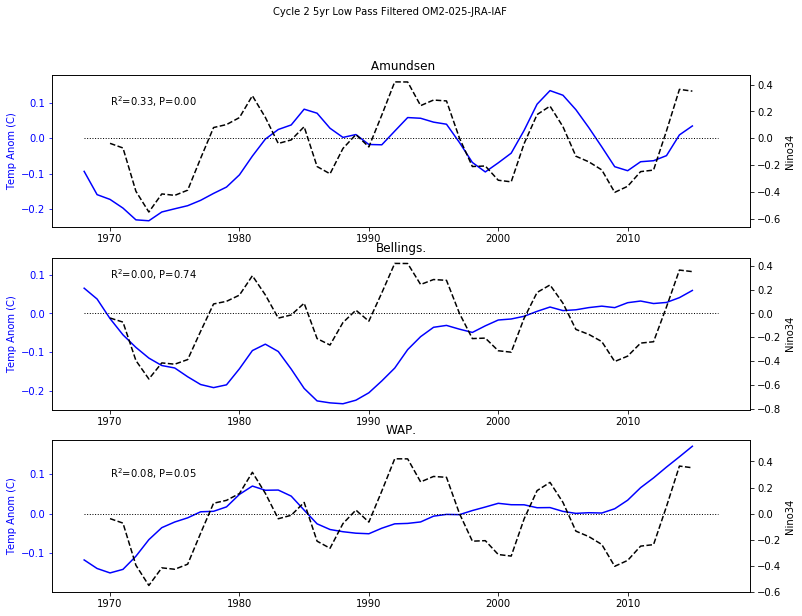

In [88]:
#as_tpert_5yr=pd.rolling_mean(as_tpert, window=5, center=True)
#bs_tpert_5yr=pd.rolling_mean(bs_tpert, window=5, center=True)
#wap_tpert_5yr=pd.rolling_mean(wap_tpert, window=5, center=True)
df= pd.DataFrame(as_tpert)
as_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(bs_tpert)
bs_tpert_5yr = df.rolling(window=5, center=True).mean().values
df= pd.DataFrame(wap_tpert)
wap_tpert_5yr = df.rolling(window=5, center=True).mean().values

plt.suptitle('Cycle 2 5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=as_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
ax2.set_ylabel('Nino34')#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=bs_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr[10:],linestyle='-',color='b',label='Amunds.',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

a=wap_tpert_5yr[10:]
b=hadsst_n34_ann_5yr
print a.shape, b.shape
c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
print c

corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
print corstr
ax1.text(1970,0.09,corstr)

In [89]:
as_tpert_cyc2=as_tpert
bs_tpert_cyc2=bs_tpert
wap_tpert_cyc2=wap_tpert

as_tpert_5yr_cyc2=as_tpert_5yr
bs_tpert_5yr_cyc2=bs_tpert_5yr
wap_tpert_5yr_cyc2=wap_tpert_5yr

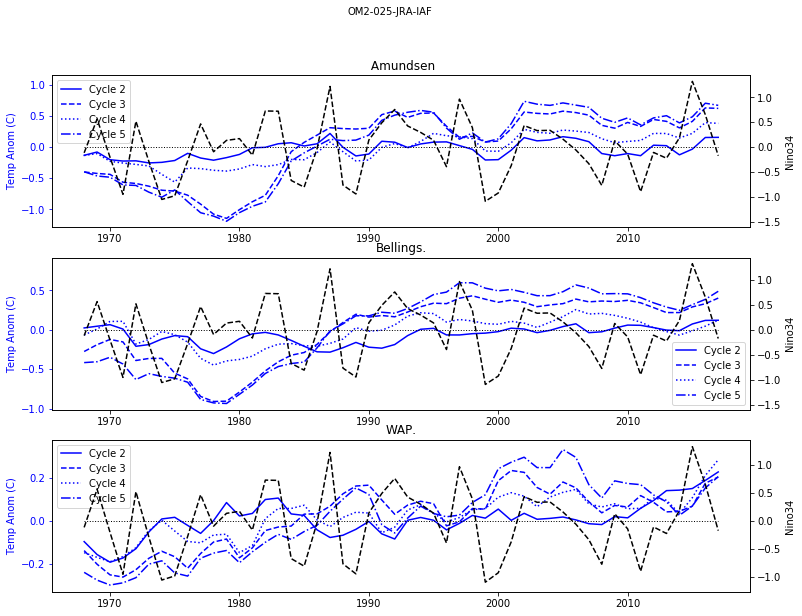

In [90]:
plt.suptitle('OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=as_tpert[10:]
#b=hadsst_n34_ann
#print a.shape, b.shape
#c= sp.stats.linregress(a[:,0],b[:,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=bs_tpert[10:]
#b=hadsst_n34_ann
#print a.shape, b.shape
#c= sp.stats.linregress(a[:,0],b[:,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.set_ylabel('Nino34')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=wap_tpert[10:]
#b=hadsst_n34_ann
#print a.shape, b.shape
#c= sp.stats.linregress(a[:,0],b[:,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

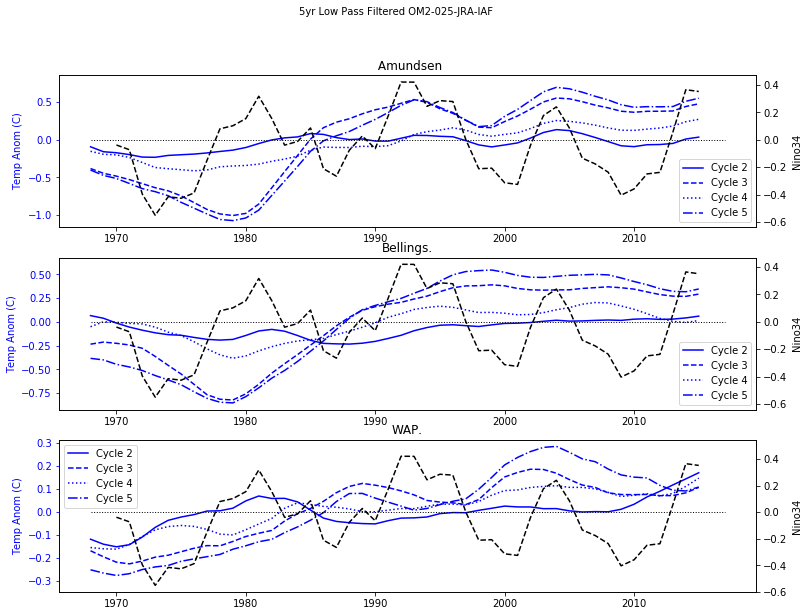

In [91]:
plt.suptitle('5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=as_tpert_5yr[10:]
#b=hadsst_n34_ann_5yr
#print a.shape, b.shape
#c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
ax2.set_ylabel('Nino34')#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=bs_tpert_5yr[10:]
#b=hadsst_n34_ann_5yr
#print a.shape, b.shape
#c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],hadsst_n34_ann_5yr,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=wap_tpert_5yr[10:]
#b=hadsst_n34_ann_5yr
#print a.shape, b.shape
#c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


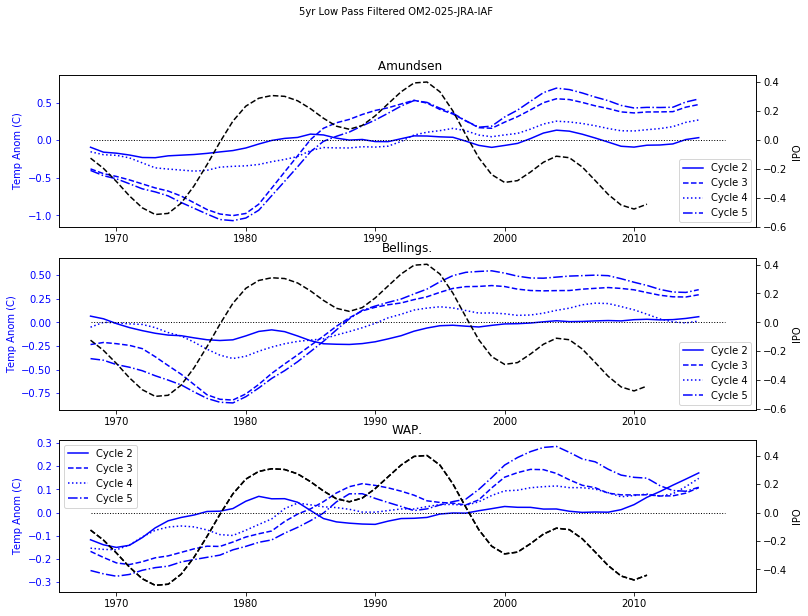

In [92]:
plt.suptitle('5yr Low Pass Filtered OM2-025-JRA-IAF', fontsize=10)

print yrs

ax1=plt.subplot(311)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],as_tpert_5yr_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title(' Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],ERSST_ipo_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=as_tpert_5yr[10:]
#b=hadsst_n34_ann_5yr
#print a.shape, b.shape
#c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

ax1=plt.subplot(312)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],bs_tpert_5yr_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellings.')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],ERSST_ipo_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
align_yaxis_np(ax1,ax2)

#a=bs_tpert_5yr[10:]
#b=hadsst_n34_ann_5yr
#print a.shape, b.shape
#c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc2[10:],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc3[10:],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc4[10:],linestyle=':',color='b',label='Cycle 4',linewidth=1.5)
ax1.plot(yrs[10:],wap_tpert_5yr_cyc5[10:],linestyle='-.',color='b',label='Cycle 5',linewidth=1.5)
#ax1.plot(yrs,as_tx_pert-as_tx_cntrl,linestyle='-',color='r',label='Taux. Amunds.',linewidth=1.5)
ax1.plot(yrs[10:],np.zeros((50,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP.')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[10:],ERSST_ipo_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.plot(yrs[10:],ERSST_ipo_ann,linestyle='--',color='k',label='Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#a=wap_tpert_5yr[10:]
#b=hadsst_n34_ann_5yr
#print a.shape, b.shape
#c= sp.stats.linregress(a[2:-2,0],b[2:-2,0])
#print c

#corstr="R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print corstr
#ax1.text(1970,0.09,corstr)